In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

/Users/ya-philya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from skimage.color import rgb2gray

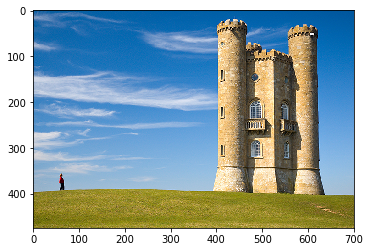

In [79]:
img = io.imread("public_data/01_input/img.png")
plt.imshow(img)
plt.show()

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


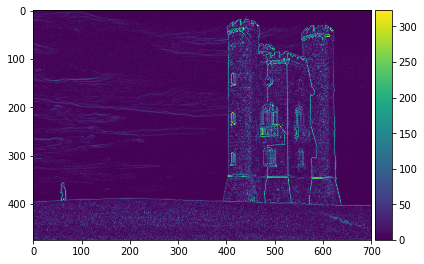

In [160]:
io.imshow(get_gradient(img))

In [177]:
def get_luminance(image):
    RC = 0.299
    GC = 0.587
    BC = 0.114
    f = image.astype(np.float64)
    return f[:,:,0] * RC + f[:,:,1] * GC + f[:,:,2] * BC

def get_gradient(image):
    lum = get_luminance(image)
    
    x_modified = np.hstack((lum[:, 0].reshape(-1, 1), lum, lum[:, -1].reshape(-1, 1)))
    dx = x_modified[:, 2:] - x_modified[:, :-2]
    
    y_modified = np.vstack((lum[0, :], lum, lum[-1, :]))
    dy = y_modified[2:, :] - y_modified[:-2, :]
    assert(dx.shape == lum.shape)
    assert(dy.shape == lum.shape)
    return np.sqrt(dx ** 2 + dy ** 2)

def get_min_horizontal_seam(grad, mask):
    def get_horizontal_min(seam, i, j):
        if j == 0:
            return np.min(seam[i - 1, j:j + 2]), np.argmin(seam[i - 1, j:j + 2])
        elif j == seam.shape[1] - 1:
            return np.min(seam[i - 1, j - 1:j + 1]), np.argmin(seam[i - 1, j - 1:j + 1]) - 1
        else:
            return np.min(seam[i - 1, j - 1:j + 2]), np.argmin(seam[i - 1, j - 1:j + 2]) - 1
    
    if mask is None:
        mask = np.zeros_like(grad)
    shape = np.array(grad.shape)
    INCR = shape.prod() * 256 
    grad += mask * INCR
    seam = np.zeros_like(grad)
    path = np.zeros_like(grad)
    
    seam[0, :] = grad[0, :]
    for i in range(1, shape[0]):
        one_part = seam[i - 1, 0:-2]
        second_part = seam[i - 1, 1:-1]
        third_part = seam[i - 1, 2:]
        tmp = np.vstack((one_part, second_part, third_part))
        central_seam, central_path = np.min(tmp, axis=0), np.argmin(tmp, axis=0) - 1
        seam[i, 1:-1] = central_seam + grad[i, 1:-1]
        path[i, 1:-1] = central_path
        seam[i, 0], path[i, 0] = get_horizontal_min(seam, i, 0)
        seam[i, 0] += grad[i, 0]
        seam[i, shape[1] - 1], path[i, shape[1] - 1] = get_horizontal_min(seam, i, shape[1] - 1)
        seam[i, shape[1] - 1] += grad[i, shape[1] - 1]
        
            
    min_seam = np.zeros(shape, np.bool)
    i = shape[0] - 1
    j = np.argmin(seam[-1, :])
    min_seam[i, j] = True
    while i != 0:
        j = int(j + path[i, j])
        i -= 1
        min_seam[i, j] = True
    return min_seam

def get_min_vertical_seam(grad, mask):
    def get_vertical_min(seam, i, j):
        if i == 0:
            return np.min(seam[i:i + 2, j - 1]), np.argmin(seam[i:i + 2, j - 1])
        elif i == seam.shape[0] - 1:
            return np.min(seam[i - 1:i + 1, j - 1]), np.argmin(seam[i - 1:i + 1, j - 1]) - 1
        else:
            return np.min(seam[i - 1:i + 2, j - 1]), np.argmin(seam[i - 1:i + 2, j - 1]) - 1
    
    if mask is None:
        mask = np.zeros_like(grad)
    shape = np.array(grad.shape)
    INCR = shape.prod() * 256 
    grad += mask * INCR
    seam = np.zeros_like(grad)
    path = np.zeros_like(grad)
    
    seam[:, 0] = grad[:, 0]
    for j in range(1, shape[1]):
        for i in range(0, shape[0]):
            seam[i, j], path[i, j] = get_vertical_min(seam, i, j)
            seam[i, j] += grad[i, j]
            
    min_seam = np.zeros(shape, np.bool)
    i = np.argmin(seam[:, -1])
    j = min_seam.shape[1] - 1
    min_seam[i, j] = True
    while j != 0:
        i = int(i + path[i, j])
        j -= 1
        min_seam[i, j] = True
    return min_seam

def horizontal_shrink(image, mask, seam):
    remain = np.logical_not(seam)
    tripled_remain = np.tile(remain[:, :, np.newaxis], 3)
    if mask is not None:
        return image[tripled_remain].reshape((seam.shape[0], seam.shape[1]- 1, 3)), mask[remain]
    else:
        return image[tripled_remain].reshape((seam.shape[0], seam.shape[1] - 1, 3)), None

def vertical_shrink(image, mask, seam):
    remain = np.logical_not(seam)
    tripled_remain = np.tile(remain[:, :, np.newaxis], 3)
    if mask is not None:
        return image[tripled_remain].reshape((seam.shape[0] - 1, seam.shape[1], 3)), mask[remain]
    else:
        return image[tripled_remain].reshape((seam.shape[0] - 1, seam.shape[1], 3)), None

def seam_carve(image, mode, mask=None):
    grad = get_gradient(image)

    if mode == 'horizontal shrink':
        min_seam = get_min_horizontal_seam(grad, mask)
        return horizontal_shrink(image, mask, min_seam) + (min_seam.astype(int),)
    elif mode == 'vertical shrink':
        min_seam = get_min_vertical_seam(grad, mask)
        return vertical_shrink(image, mask, min_seam) + (min_seam.astype(int),)
    elif mode == 'horizontal expand':
        min_seam = get_min_horizontal_seam(grad, mask)
        return image, mask, min_seam.astype(int)
    else:
        min_seam = get_min_vertical_seam(grad, mask)
        return image, mask, min_seam.astype(int)

In [118]:
%%time
new_img, new_mask, seam = seam_carve(img, 'horizontal shrink', mask)

CPU times: user 2.19 s, sys: 20.1 ms, total: 2.21 s
Wall time: 2.07 s


In [119]:
new_img.shape, img.shape

((475, 699, 3), (475, 700, 3))

In [173]:
np.nonzero([[0,0,1,0],[0,1,0,0], [0,0,1,0]])

(array([0, 1, 2]), array([2, 1, 2]))

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


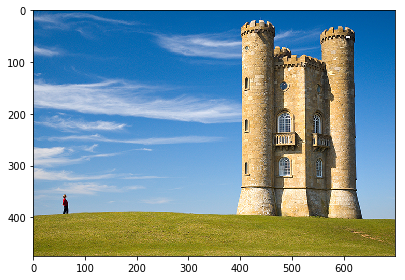

In [120]:
io.imshow(new_img)

In [ ]:
np.nonzero()

In [50]:
grad = get_gradient(img)

In [98]:
np.tile(seam[:, :, np.newaxis], 3).shape

(475, 700, 3)

In [63]:
mask = np.zeros_like(grad)

In [66]:
mask[m_s] = 1

In [73]:
for k in range(5):
    mask[m_s] = 1
    m_s = get_min_horizontal_seam(grad, mask)
    img[m_s] = [1,0,0]

In [ ]:
m_s.astype()

In [186]:
!python script.py public_data

bjhvjhvhjvhjvhjvhjvjhvjhvjvhgv
01 9.91s Ok 8/8
02 8.72s Ok 8/8
03 8.79s Ok 8/8
04 3.74s Ok 8/8
05 2.77s Ok 8/8
06 7.22s Ok 8/8
07 4.98s Ok 8/8
Mark: 10 56 / 56


In [180]:
np.argmin([[0, 1, 2, 3, 4], [1, 2, 1, 3, 3], [2, 0, 2, 3, 3]], axis=0)

array([0, 2, 1, 0, 1])

In [184]:
np.argmin(np.vstack(([0, 1, 2, 3, 4], [1, 2, 1, 3, 3], [2, 0, 2, 3, 3])), axis=0)

array([0, 2, 1, 0, 1])